# Solving the n-Queens Problem using Local Search

Student Name:

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]


## Learning Outcomes

* Implement multiple hill climbing search variants to solve the n-Queens problem.
* Apply simulated annealing with appropriate temperature scheduling to overcome local optima.
* Compare algorithm performance using runtime, solution quality, and success rate metrics.
* Analyze and visualize algorithm performance across different problem sizes.
* Graduate Students: Design and test alternative local move operators to improve search efficiency.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.

## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum.

## Helper functions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

np.random.seed(1234)


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""

    return(np.random.randint(0,n, size = n))

def comb2(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

def conflicts(board):
    """Calculate the number of conflicts, i.e., the objective function."""

    n = len(board)

    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n

    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1

    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))

# decrease the font size to fit larger boards
def show_board(board, cols = ['white', 'gray'], fontsize = 48):
    """display the board"""

    n = len(board)

    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0):
                display[i,j] = 1

    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap,
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])

    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = fontsize,
                 horizontalalignment = 'center',
                 verticalalignment = 'center')

    print(f"Board with {conflicts(board)} conflicts.")
    plt.show()

## Create a board

Board with 4 conflicts.


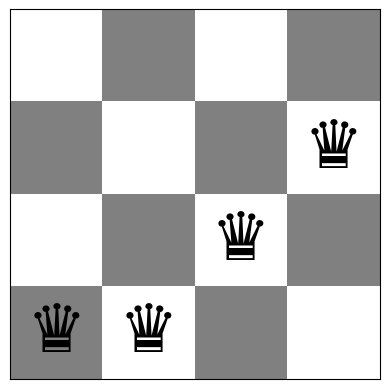

Queens (left to right) are at rows: [3 3 2 1]
Number of conflicts: 4


In [5]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")

A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


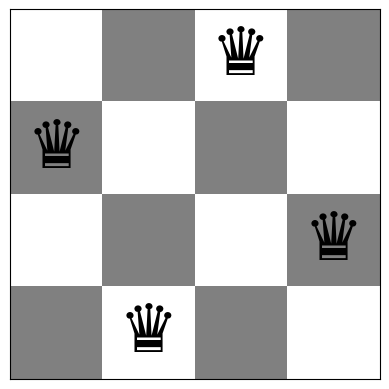

In [6]:
board = [1,3,0,2]
show_board(board)

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Steepest-ascend Hill Climbing Search [20 Points]

Calculate the objective function for all local moves (see definition of local moves above) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum.

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def steepest_ascent_hill_climbing(n, max_steps=1000, verbose=True, plot=True, show=True):
    # Initialize a random board
    current_board = random_board(n)
    current_conflicts = conflicts(current_board)
    conflict_history = [current_conflicts]  # Track conflict values over time

    if verbose:
        print(f"Initial board: {current_board} | Conflicts = {current_conflicts}")

    # Repeat until the maximum number of steps is reached
    for step in range(max_steps):
        best_board = current_board.copy()
        best_conflicts = current_conflicts
        improvement_found = False  # Flag to check if any better move is found

        # Explore all possible moves (move one queen in each column)
        for col in range(n):
            original_row = current_board[col]
            for new_row in range(n):
                if new_row == original_row:
                    continue  # Skip if the queen stays in the same row

                # Create a new board for this potential move
                next_board = current_board.copy()
                next_board[col] = new_row
                next_conflicts = conflicts(next_board)

                # If this move reduces conflicts, keep it as the best move
                if next_conflicts < best_conflicts:
                    best_conflicts = next_conflicts
                    best_board = next_board.copy()
                    improvement_found = True

        # Stop if no better move exists (local optimum)
        if not improvement_found or best_conflicts >= current_conflicts:
            if verbose:
                print(f"Stopped after {step} steps (local optimum) | Conflicts = {current_conflicts}")
            break

        # Move to the best neighbor found
        current_board = best_board
        current_conflicts = best_conflicts
        conflict_history.append(current_conflicts)

        # If a perfect solution is found (0 conflicts), stop early
        if current_conflicts == 0:
            if verbose:
                print(f"Found solution after {step+1} steps!")
            break

    # Plot the conflict history (optional)
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(conflict_history, marker='o', color='blue')
        plt.title(f"Steepest-Ascent Hill Climbing (n={n})")
        plt.xlabel("Step")
        plt.ylabel("Number of Conflicts")
        plt.grid(True)
        if show:
            plt.show()

    # Return final result
    return current_board, current_conflicts


Initial board: [1 2 2 0] | Conflicts = 3
Stopped after 1 steps (local optimum) | Conflicts = 1


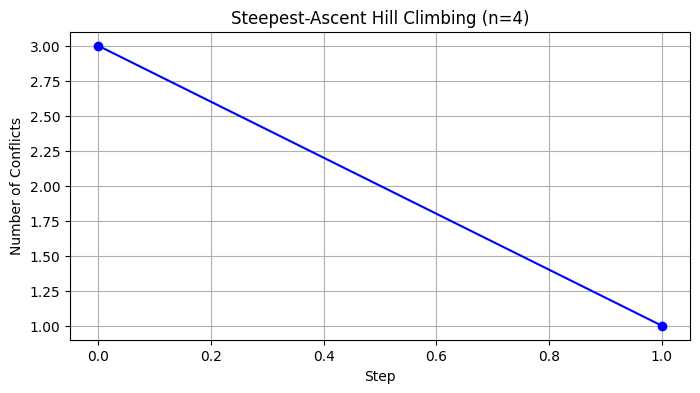

Final board: [1 3 2 0]
Final conflicts: 1
Board with 1 conflicts.


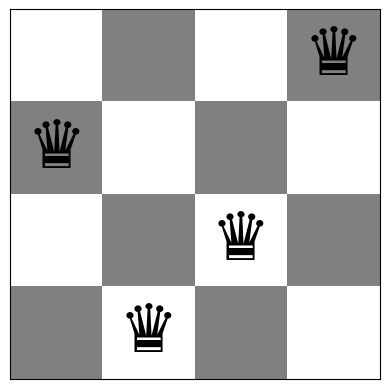

In [68]:
# Run & visualize
n = 4
solution, c = steepest_ascent_hill_climbing(n)
print("Final board:", solution)
print("Final conflicts:", c)
show_board(solution)

## Task 2: Stochastic Hill Climbing 1 [10 Points]

Chooses randomly from among all uphill moves till you have reached a local optimum.

In [69]:
import random
import matplotlib.pyplot as plt

def stochastic_hill_climbing(n, max_steps=1000, verbose=True, plot=True, show=True):
    # Initialize the starting board and compute its conflicts
    current_board = random_board(n)
    current_conflicts = conflicts(current_board)
    conflict_history = [current_conflicts]

    if verbose:
        print(f"Initial board: {current_board} | Conflicts = {current_conflicts}")

    # Main search loop
    for step in range(max_steps):
        improving_moves = []  # Store all moves that improve the current state

        # Evaluate all possible single-queen moves
        for col in range(n):
            original_row = current_board[col]
            for new_row in range(n):
                if new_row == original_row:
                    continue  # Skip if the queen remains in the same row

                # Create a candidate board for this move
                candidate_board = current_board.copy()
                candidate_board[col] = new_row
                candidate_conflicts = conflicts(candidate_board)

                # Keep only moves that reduce the number of conflicts
                if candidate_conflicts < current_conflicts:
                    improving_moves.append((candidate_board, candidate_conflicts))

        # If no improving moves exist, stop at a local optimum
        if not improving_moves:
            if verbose:
                print(f"Stopped after {step} steps (local optimum) | Conflicts = {current_conflicts}")
            break

        # Randomly choose one of the improving moves
        chosen_board, chosen_conflicts = random.choice(improving_moves)

        # Update the current state to the chosen move
        current_board = chosen_board
        current_conflicts = chosen_conflicts
        conflict_history.append(current_conflicts)

        # If a perfect solution (0 conflicts) is found, stop early
        if current_conflicts == 0:
            if verbose:
                print(f"Found solution after {step+1} steps!")
            break

    # Plot the conflict reduction history if requested
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(conflict_history, marker='o', color='orange')
        plt.title(f"Stochastic Hill Climbing (n={n})")
        plt.xlabel("Step")
        plt.ylabel("Number of Conflicts")
        plt.grid(True)
        if show:
            plt.show()

    # Return the final board and its conflict count
    return current_board, current_conflicts


Initial board: [2 3 2 3] | Conflicts = 5
Stopped after 4 steps (local optimum) | Conflicts = 1


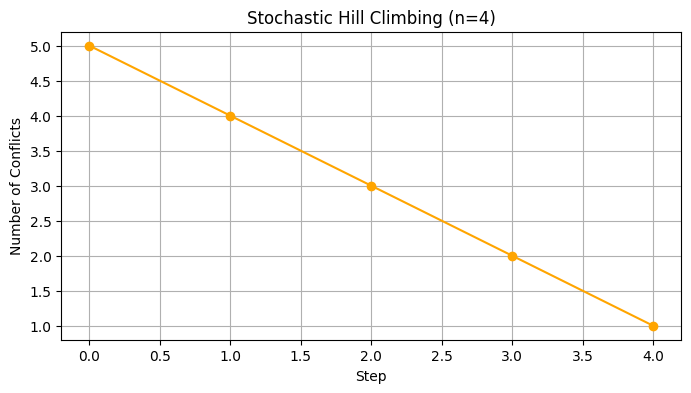

Final board: [0 2 3 1]
Final conflicts: 1
Board with 1 conflicts.


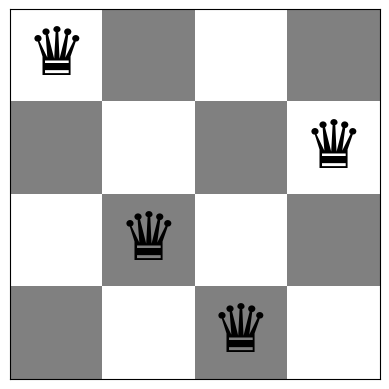

In [70]:
# Run & visualize
n = 4
solution, c = stochastic_hill_climbing(n)
print("Final board:", solution)
print("Final conflicts:", c)
show_board(solution)

## Task 3: Stochastic Hill Climbing 2 [20 Points]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

In [72]:
import random
import matplotlib.pyplot as plt

def first_choice_hill_climbing(n, max_steps=10000, patience=200, verbose=True, plot=True, show=True):
    # Initialize the board and compute its conflicts
    board = random_board(n)
    current_conflicts = conflicts(board)
    conflict_history = [current_conflicts]
    no_improve_count = 0  # Counts consecutive non-improving moves

    if verbose:
        print(f"Initial board: {board} | Conflicts = {current_conflicts}")

    # Main loop
    for step in range(max_steps):
        # Randomly select one queen to move
        col = random.randint(0, n - 1)
        new_row = random.randint(0, n - 1)
        # Ensure the new position differs from the current one
        while new_row == board[col]:
            new_row = random.randint(0, n - 1)

        # Create a new board with this random move
        new_board = board.copy()
        new_board[col] = new_row
        new_conflicts = conflicts(new_board)

        # Accept the move immediately if it improves the board
        if new_conflicts < current_conflicts:
            board = new_board
            current_conflicts = new_conflicts
            conflict_history.append(current_conflicts)
            no_improve_count = 0  # Reset patience counter

            # Stop early if a perfect solution is found
            if verbose and current_conflicts == 0:
                print(f"Found perfect solution after {step + 1} steps!")
                break
        else:
            # Otherwise, increase patience counter
            no_improve_count += 1

        # Stop if no improvement for too long
        if no_improve_count >= patience:
            if verbose:
                print(f"Stopped after {step + 1} steps (no improvement in {patience} tries).")
            break

        # Safety check: end if perfect solution already found
        if current_conflicts == 0:
            break

    # Plot the conflict reduction history if requested
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(conflict_history, marker='o', color='green')
        plt.title(f"First-Choice Hill Climbing (n={n})")
        plt.xlabel("Step")
        plt.ylabel("Number of Conflicts")
        plt.grid(True)
        if show:
            plt.show()

    # Return the final result
    return board, current_conflicts


Initial board: [1 3 1 2] | Conflicts = 2
Found perfect solution after 7 steps!


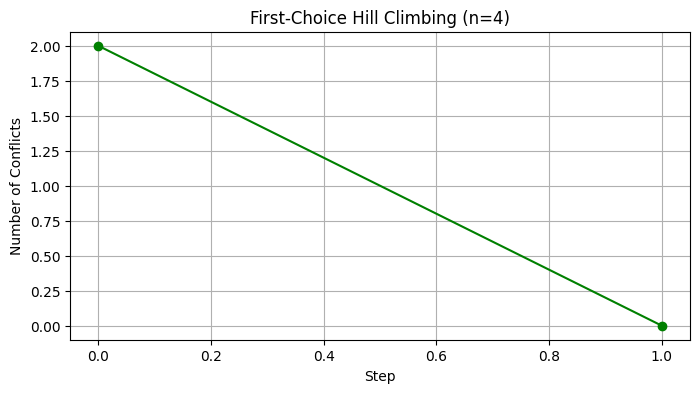

Final board: [1 3 0 2]
Final conflicts: 0
Board with 0 conflicts.


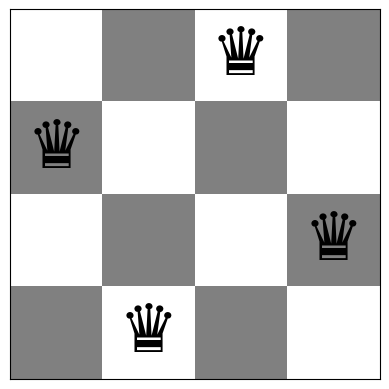

In [73]:
# Run & visualize
n = 4
solution, c = first_choice_hill_climbing(n)
print("Final board:", solution)
print("Final conflicts:", c)
show_board(solution)

## Task 4: Hill Climbing Search with Random Restarts [10 Points]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algorithm several times starting with a new random board.

In [75]:
def random_restart_hill_climbing(algorithm_func, n, restarts=100, verbose=True):
    best_board = None
    best_conflicts = float('inf')

    for i in range(restarts):
        # Run the given hill climbing algorithm once
        # Disable verbose and plotting for faster performance inside restarts
        board, conflicts = algorithm_func(n, verbose=False, plot=False)

        # Keep track of the best result across all restarts
        if conflicts < best_conflicts:
            best_conflicts = conflicts
            best_board = board

        if verbose:
            print(f"Restart {i + 1}/{restarts} -> Conflicts: {conflicts}")

        # Stop early if a perfect solution is found
        if best_conflicts == 0:
            if verbose:
                print(f"Perfect solution found at restart {i + 1}")
            break

    # Print summary after all restarts
    if verbose:
        print(f"\nBest result after {restarts} restarts: {best_conflicts} conflicts")
        print("Best board:", best_board)
        show_board(best_board)

    return best_board, best_conflicts


=== Steepest-Ascent Hill Climbing (Random Restart) ===
Restart 1/100 -> Conflicts: 0
Perfect solution found at restart 1

Best result after 100 restarts: 0 conflicts
Best board: [1 3 0 2]
Board with 0 conflicts.


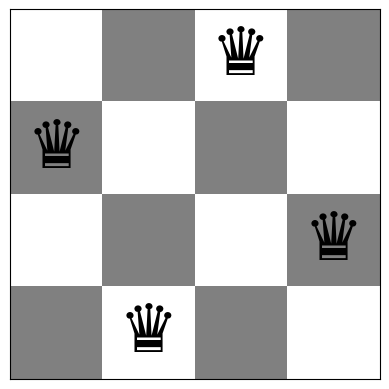


=== Stochastic Hill Climbing 1 (Random Restart) ===
Restart 1/100 -> Conflicts: 1
Restart 2/100 -> Conflicts: 1
Restart 3/100 -> Conflicts: 1
Restart 4/100 -> Conflicts: 0
Perfect solution found at restart 4

Best result after 100 restarts: 0 conflicts
Best board: [1 3 0 2]
Board with 0 conflicts.


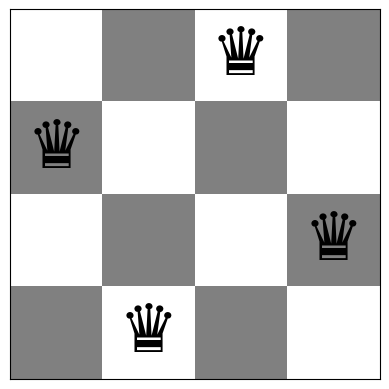


=== First-Choice Hill Climbing (Random Restart) ===
Restart 1/100 -> Conflicts: 1
Restart 2/100 -> Conflicts: 1
Restart 3/100 -> Conflicts: 0
Perfect solution found at restart 3

Best result after 100 restarts: 0 conflicts
Best board: [2 0 3 1]
Board with 0 conflicts.


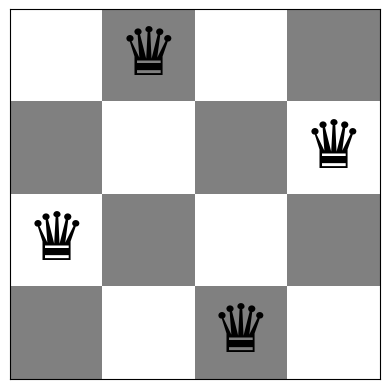

(array([2, 0, 3, 1]), 0)

In [76]:
# --- Example Tests ---
n = 4

print("=== Steepest-Ascent Hill Climbing (Random Restart) ===")
random_restart_hill_climbing(steepest_ascent_hill_climbing, n)

print("\n=== Stochastic Hill Climbing 1 (Random Restart) ===")
random_restart_hill_climbing(stochastic_hill_climbing, n)

print("\n=== First-Choice Hill Climbing (Random Restart) ===")
random_restart_hill_climbing(first_choice_hill_climbing, n)


## Task 5: Simulated Annealing [10 Points]

Simulated annealing is a form of stochastic hill climbing that avoid local optima by also allowing downhill moves with a probability proportional to a temperature. The temperature is decreased in every iteration following an annealing schedule. You have to experiment with the annealing schedule (Google to find guidance on this).


1. Implement simulated annealing for the n-Queens problem.
2. Create a visualization of the search process (a line chart of how the number if conflict changes as the algorithm progrsses).
3. Use this visualization for experiments with different choices for the annealing schedule and discuss what you have learned.

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

def simulated_annealing(n, T0=1000, cooling_rate=0.99, max_steps=10000, verbose=True, plot=True, show=True):
    # Initialize with a random state
    current_board = random_board(n)
    current_conflicts = conflicts(current_board)

    # Track the best solution encountered
    best_board = current_board.copy()
    best_conflicts = current_conflicts

    # Temperature and logging
    T = float(T0)
    conflicts_history = [current_conflicts]

    for step in range(max_steps):
        # Early exit if solved
        if current_conflicts == 0:
            break

        # --- Propose a random neighbor: move one queen to a different row ---
        col = random.randint(0, n - 1)
        new_row = random.randint(0, n - 1)
        while new_row == current_board[col]:  # ensure an actual move
            new_row = random.randint(0, n - 1)

        candidate = current_board.copy()
        candidate[col] = new_row
        candidate_conflicts = conflicts(candidate)

        # Energy difference (we minimize conflicts, so ΔE = new - current)
        deltaE = candidate_conflicts - current_conflicts

        # Acceptance rule: always accept improvements; sometimes accept worse moves
        if deltaE < 0:
            # Improvement
            current_board = candidate
            current_conflicts = candidate_conflicts
        else:
            # Probabilistic acceptance of worse states
            if T > 0.0:
                accept_prob = math.exp(-deltaE / T)
                if random.random() < accept_prob:
                    current_board = candidate
                    current_conflicts = candidate_conflicts

        # Cool down and log
        T *= cooling_rate
        conflicts_history.append(current_conflicts)

        # Update global best
        if current_conflicts < best_conflicts:
            best_conflicts = current_conflicts
            best_board = current_board.copy()

    if verbose:
        print(f"Best conflicts: {best_conflicts}")
        show_board(best_board)

    # Optional plotting of the conflict trajectory
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(conflicts_history, marker='o')
        plt.title(f"Simulated Annealing (n={n}, T0={T0}, cooling={cooling_rate})")
        plt.xlabel("Step")
        plt.ylabel("Number of Conflicts")
        plt.grid(True)
        if show:
            plt.show()

    return best_board, best_conflicts, conflicts_history


Best conflicts: 0
Board with 0 conflicts.


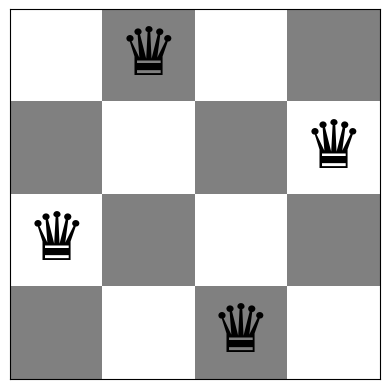

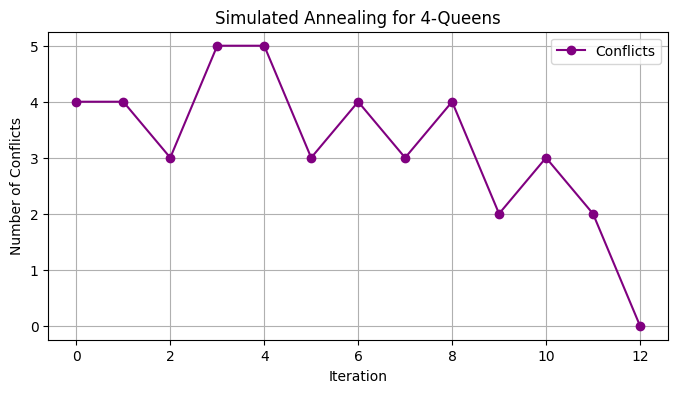

In [78]:
n = 4  # board size
board, best_conflicts, history = simulated_annealing(
    n,
    T0=1000,          # initial temperature
    cooling_rate=0.99, # cooling factor per iteration
    max_steps=5000,    # maximum iterations
    verbose=True,      # print final summary
    plot=False         # disable internal plot
)

# --- Plot the conflict history ---
plt.figure(figsize=(8, 4))
plt.plot(history, label='Conflicts', color='purple', marker='o')
plt.title(f"Simulated Annealing for {n}-Queens")
plt.xlabel("Iteration")
plt.ylabel("Number of Conflicts")
plt.legend()
plt.grid(True)
plt.show()


## Task 6: Algorithm Behavior Analysis [20 Points]

### Comparison
Compare the algorithm using runtime and objective function values. Use boards of size 4 and 8 to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 100 times) with different starting boards and report averages.

Complete the following table

| Algorithm           | Board size | Avg. Run time | Avg. number of conflicts | % of runs ending in optimal solution  |
| ------------------- | ---------- | ------------- | --------------------------------- | - |
| Steepest asc. HC    |     4      |               |                                   |   |
| Stochastic HC 1     |     4      |               |                                   |   |
| Stochastic HC 2     |     4      |               |                                   |   |
| Simulated Annealing |     4      |               |                                   |   |
| Steepest asc. HC    |     8      |               |                                   |   |
| Stochastic HC 1     |     8      |               |                                   |   |
| Stochastic HC 2     |     8      |               |                                   |   |
| Simulated Annealing |     8      |               |                                   |   |

Hint: See [Profiling Python Code](../HOWTOs/profiling_code.ipynb) for help about how to measure runtime in Python.

Add the used code here:

In [79]:
import time
import random
import numpy as np
import pandas as pd

def _safe_call(algo, n):
    try:
        return algo(n, verbose=False, plot=False, show=False)
    except TypeError:
        try:
            return algo(n, verbose=False)
        except TypeError:
            return algo(n)

def _conf_from_result(res):
    if isinstance(res, tuple):
        return int(res[1]) if len(res) >= 2 else int(res[-1])
    if isinstance(res, dict):
        for k in ("conflicts", "num_conflicts", "h", "cost"):
            if k in res:
                return int(res[k])
        raise ValueError("No conflict field found in the result dict.")
    if isinstance(res, (int, np.integer)):
        return int(res)
    raise ValueError("Could not extract the number of conflicts from the result.")

def _bench_once(algo, n):
    """Run a single trial and return (runtime_seconds, conflicts)."""
    t0 = time.perf_counter()
    out = _safe_call(algo, n)
    dt = time.perf_counter() - t0
    return dt, _conf_from_result(out)

def evaluate_algo(algo, n, runs=100, seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    t_sum = 0.0
    c_sum = 0
    solved = 0

    for _ in range(runs):
        dt, c = _bench_once(algo, n)
        t_sum += dt
        c_sum += c
        solved += (c == 0)

    avg_t = t_sum / runs
    avg_c = c_sum / runs
    suc = 100.0 * solved / runs
    return avg_t, avg_c, suc

def run_benchmark(runs=100, seed=None):
    algo_list = [
        ("Steepest asc. HC",   steepest_ascent_hill_climbing),
        ("Stochastic HC 1",    stochastic_hill_climbing),
        ("Stochastic HC 2",    first_choice_hill_climbing),
        ("Simulated Annealing", simulated_annealing),
    ]

    sizes = [4, 8]
    rows = []

    for sz in sizes:
        print(f"\n=== Benchmark n = {sz} (runs={runs}) ===")
        for name, fn in algo_list:
            avg_t, avg_c, suc = evaluate_algo(fn, sz, runs=runs, seed=seed)
            print(f"{name:22s} | time={avg_t:.6f}s | conf={avg_c:.2f} | success={suc:.1f}%")
            rows.append({
                "Algorithm": name,
                "Board size": sz,
                "Avg. Run time (s)": round(avg_t, 6),
                "Avg. number of conflicts": round(avg_c, 2),
                "% of runs ending in optimal solution": f"{suc:.1f}%"
            })

    df = pd.DataFrame(rows, columns=[
        "Algorithm",
        "Board size",
        "Avg. Run time (s)",
        "Avg. number of conflicts",
        "% of runs ending in optimal solution",
    ])

    print("\n--- Summary ---")
    try:
        print(df.to_markdown(index=False, tablefmt="grid"))  # bordered table
    except Exception:
        print(df.to_string(index=False))
    return df

# Run Task 6 (rewrite)
# For realistic randomness, keep seed=None. Set seed=1234 for reproducibility.
df_results = run_benchmark(runs=100, seed=None)



=== Benchmark n = 4 (runs=100) ===
Steepest asc. HC       | time=0.000227s | conf=0.64 | success=45.0%
Stochastic HC 1        | time=0.000267s | conf=0.95 | success=25.0%
Stochastic HC 2        | time=0.001183s | conf=0.79 | success=38.0%
Simulated Annealing    | time=0.001955s | conf=0.00 | success=100.0%

=== Benchmark n = 8 (runs=100) ===
Steepest asc. HC       | time=0.005364s | conf=1.17 | success=15.0%
Stochastic HC 1        | time=0.007718s | conf=1.26 | success=12.0%
Stochastic HC 2        | time=0.006250s | conf=1.31 | success=9.0%
Simulated Annealing    | time=0.028107s | conf=0.03 | success=97.0%

--- Summary ---
+---------------------+--------------+---------------------+----------------------------+----------------------------------------+
| Algorithm           |   Board size |   Avg. Run time (s) |   Avg. number of conflicts | % of runs ending in optimal solution   |
+=====================+==============+=====================+============================+================

### Algorithm Convergence

For each algorithm implemented, describe the typical convergence pattern (fast initial improvement vs. steady progress).
Include a plot showing the objective function value over iterations for one representative run of each algorithm on the 8-queens problem.
Explain which algorithms exhibit plateaus or getting stuck in local optima most frequently.

In [ ]:
# Code and description go here

### Problem Size Scalability

Create a log-log plot showing how runtime scales with board size ($n=4, 8, 12, 16, 20$) for at least two algorithms.
Estimate the empirical time complexity (Big O) for each algorithm based on your results.
Identify which algorithm scales best for large problem sizes and explain why.

In [ ]:
# Code and description go here

## Advanced task: Exploring other Local Moves Operators

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### Move Operator Implementation

Implement the following local move operators:

* Single-step move: Move one queen only one square up or down at a time
* Column swap: Exchange the positions of queens in two randomly selected columns
* Dual-queen move: Select two queens and move both simultaneously
* Adaptive move: Design your own operator that adapts which local move it uses based on the current state (e.g., focuses on queens with most conflicts or randomly chooses one of the moves above)

### Experimental Analysis

Using the 8-Queens and 12-Queens problems: Run your Stochastic Hill Climbing 2 implementation with each move operator 100 times
For each operator, create a visualization showing:

* Average solution quality over iterations
* Distribution of final solution qualities
* Average time to solution for successful runs

### Discussion

Describe what you have learned from the experiments. Which operator works best for which situation and why?

In [ ]:
# Code and description go here

## More Things to Do (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment.

### Implement a Genetic Algorithm for the n-Queens problem

In [ ]:
# Code and description go here